In [1]:
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import altair as alt
from altair.expr import datum

In [2]:
# we need to run this line to use Altair in a Jupyter notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
ROOT = os.path.abspath(os.path.pardir)
DB_NAME = 'Pokemon.db'
DB_PATH = os.path.abspath(os.path.join(ROOT, DB_NAME))
PLOTS_PATH = os.path.abspath(os.path.join(ROOT, 'plots'))
print(DB_PATH)
print(PLOTS_PATH)

/home/giacomo/repos/reddit-dataviz-battle-2018-09/Pokemon.db
/home/giacomo/repos/reddit-dataviz-battle-2018-09/plots


In [82]:
COLOR_RULE = '#969696'
COLOR_RULE_BETWEEN = '#d9d9d9'
COLOR_BACKGROUND = '#d9d9d9'

In [83]:
engine = sa.create_engine(f"sqlite:///{DB_PATH}")

## Facet Grid

In [84]:
def make_hcc(row_of_charts):
    hconcat = [chart for chart in row_of_charts]
    hcc = alt.HConcatChart(hconcat=hconcat)
    return hcc

In [85]:
def facet_wrap(charts, charts_per_row):
    rows_of_charts = [charts[i:i+charts_per_row] for i in range(0, len(charts), charts_per_row)]
    vconcat = [make_hcc(r) for r in rows_of_charts]
    vcc = alt.VConcatChart(vconcat=vconcat)
    return vcc

## Slopegraph

In [86]:
sql = '''
SELECT
  p.generation,
  p.type1,
  AVG(p.attack) AS attack,
  AVG(p.defense) AS defense,
  AVG(p.speed) AS speed,
  AVG(p.hp) AS hp,
  COUNT(*) AS count
FROM pokemons AS p
GROUP BY p.generation, type1
'''
df_wide = pd.read_sql(sql, con=engine)
print(df_wide.shape)
df_wide.head()

(114, 7)


,generation,type1,attack,defense,speed,hp,count
0,1,bug,71.250000,58.750000,64.583333,55.416667,12
1,1,dragon,94.000000,68.333333,66.666667,64.333333,3
2,1,electric,61.444444,64.111111,100.000000,54.444444,9
3,1,fairy,57.500000,60.500000,47.500000,82.500000,2
4,1,fighting,102.857143,61.000000,66.142857,63.571429,7


In [87]:
def wide_to_long(df_wide):
    """Unpivot the dataframe from 'wide' format to 'long' format."""
    value_vars = df_wide.columns[~df_wide.columns.isin(['generation', 'type1', 'count'])].tolist()
    df_wide.index.name = 'index'
    df_long = df_wide.reset_index()\
      .melt(
        id_vars=['index', 'generation', 'type1'],
        value_vars=value_vars,
        var_name=['attribute'], value_name='value')\
      .round({'value': 1})
    
    df_wide.reset_index(inplace=True, drop=True)
    df_long.drop(columns=['index'], inplace=True)
    return df_long

In [88]:
df_long = wide_to_long(df_wide)
df_long.head()

,generation,type1,attribute,value
0,1,bug,attack,71.2
1,1,dragon,attack,94.0
2,1,electric,attack,61.4
3,1,fairy,attack,57.5
4,1,fighting,attack,102.9


In [89]:
num_generations = len(df_wide.generation.unique())
num_generations

7

In [90]:
def get_intervals_in_generation(df_long, type1, generation):
    bottom_y = 0
    top_y = df_long[df_long.type1 == type1].value.max()
    values = df_long[(df_long.generation == generation) & (df_long.type1 == type1)].value.tolist()
    values = sorted(np.unique(values + [bottom_y, top_y]))
    num_intervals = len(values) - 1
    intervals = [[values[0], values[1]], [values[-2], values[-1]]]
    return intervals

In [91]:
df_long[df_long.type1 == 'fire'].value.max()

95.0

In [92]:
get_intervals_in_generation(df_long, 'fire', generation=4)

[[0.0, 68.0], [85.0, 95.0]]

In [93]:
# TODO: refactor. Make it more functional
def get_df_intervals(df_long):
    records = []
    for type1 in df_long.type1.unique():
        intervals_all_generations = [
            get_intervals_in_generation(df_long, type1, i+1) for i in range(num_generations)
        ]
        for i, intervals_one_generation in enumerate(intervals_all_generations):
            for interval in intervals_one_generation:
                record = {
                    'type1': type1, 'generation': i + 1, 'y1': interval[0], 'y2': interval[1]
                }
                records.append(record)
    df = pd.DataFrame(data=records, columns=['type1', 'generation', 'y1', 'y2'])
    return df

In [94]:
df_intervals = get_df_intervals(df_long)
df_intervals[(df_intervals.type1 == 'fire') & (df_intervals.generation == 1)]

,type1,generation,y1,y2
70,fire,1,0.0,62.6
71,fire,1,84.8,95.0


In [95]:
# http://colorbrewer2.org/?type=qualitative&scheme=Paired&n=4
color_range = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']

In [96]:
WIDTH = 50

In [137]:
def make_rule(df_long, type1, is_start=False, font_size=12, padding=5):
    title = f'{type1}' if is_start else ''
    generation = 1 if is_start else len(df_long.generation.unique())
    align = 'right' if is_start else 'left'
    dx = -padding if is_start else padding
    
    df_intervals = get_df_intervals(df_long)
    bottom_y = 0
    top_y = df_intervals[df_intervals.type1 == type1].y2.max()
    
    rule = alt.Chart(df_long).mark_rule(
        stroke=COLOR_RULE,
        strokeWidth=0.5
      )\
      .encode(
        x=alt.X('generation:O', axis=alt.Axis(title='', grid=False)),
      )\
      .transform_filter(datum.generation == generation)

    texts = alt.Chart(df_long).mark_text(
        align=align,
        angle=0,
        dx=dx,
        dy=padding,
        fontSize=font_size,
        fontWeight='bold',
        fillOpacity=1.0
      )\
      .encode(
        x=alt.X('generation:O', axis=alt.Axis(title='', grid=False)),
        y=alt.Y('value:Q', axis=alt.Axis(title=title, grid=False)),
        color=alt.Color('attribute:N', legend=None, scale=alt.Scale(range=color_range)),
        text='value:Q'
      )\
      .transform_filter(datum.type1 == type1)\
      .transform_filter(datum.generation == generation)
    
    df = pd.DataFrame({'generation': [generation], 'y': [0]})
    label = alt.Chart(df).mark_text(
        align='center',
        angle=0,
        dy=font_size + padding,
        fontSize=font_size
      )\
      .encode(
        x=alt.X('generation:O', axis=alt.Axis(title='', grid=False)),
        y=alt.Y('y', axis=alt.Axis(title=title, grid=False)),
        text='generation:O'
      )
    return rule + texts + label

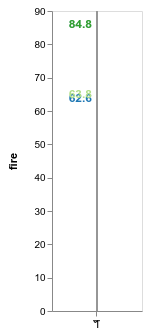

In [138]:
make_rule(df_long, 'fire', is_start=True)

In [139]:
df_intervals = get_df_intervals(df_long)
top_y = df_intervals[df_intervals.type1 == 'fire'].y2.max()
top_y

95.0

In [140]:
def make_lines(df_long, type1, i):
    title = f'{type1}' if i == 0 else ''
    
    bottom_x = i+1
    top_x = i+2
    bottom_y = df_long[df_long.type1 == type1].value.min()
    top_y = df_long[df_long.type1 == type1].value.max()

    lines = alt.Chart(df_long).mark_line()\
      .encode(
        x=alt.X(
          'generation:O',
          axis=alt.Axis(title='', grid=False),
          scale=alt.Scale(domain=(bottom_x, top_x))
        ),
        y=alt.Y(
          'value:Q',
          axis=alt.Axis(title=title, grid=False), 
          scale=alt.Scale(domain=(bottom_y, top_y))
        ),
        color=alt.Color('attribute:N', title='Attribute', scale=alt.Scale(range=color_range))
      )\
      .transform_filter(datum.type1 == type1)\
      .transform_filter((datum.generation >= i+1) & (datum.generation <= i+2))
    return lines

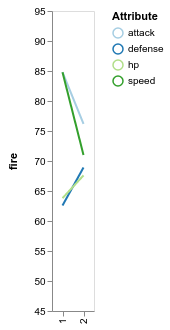

In [141]:
make_lines(df_long, type1='fire', i=0)

In [142]:
def make_start_chart(df_long, type1, font_size=12, padding=5):
    lines = make_lines(df_long, type1, i=0)
    rule = make_rule(df_long, type1, is_start=True, font_size=font_size, padding=padding)
    layer_chart = lines + rule
    return layer_chart

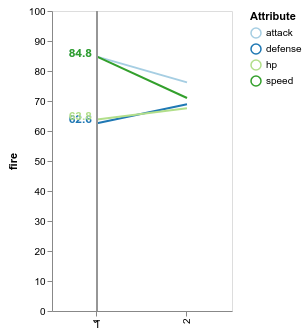

In [143]:
make_start_chart(df_long, 'fire')

In [153]:
def make_rule_between(df_long, type1, i, font_size=12, padding=5):
    df_intervals = get_df_intervals(df_long)
    bottom_y = 0
    top_y = df_intervals[df_intervals.type1 == type1].y2.max()
    
    rule = alt.Chart(df_intervals).mark_rule(
        stroke=COLOR_RULE_BETWEEN,
        strokeWidth=1.0,
        strokeOpacity=0.5,
        xOffset=-WIDTH/2.0,
      )\
      .encode(
        x=alt.X('generation:O', axis=alt.Axis(title='', grid=False)),
      )\
      .transform_filter(datum.type1 == type1)\
      .transform_filter(datum.generation == i+1)
    
    texts = alt.Chart(df_long).mark_text(
        align='center',
        dx=-WIDTH/2.0,
        dy=padding,
        fontSize=font_size,
        fontWeight='bold',
        fillOpacity=1.0
      )\
      .encode(
        x='generation:O',
        y='value:Q',
        color=alt.Color('attribute:N', legend=None, scale=alt.Scale(range=color_range)),
        text='value:Q'
      )\
      .transform_filter(datum.type1 == type1)\
      .transform_filter(datum.generation == i+1)
    
    df = pd.DataFrame({'generation': [i+1], 'y': [0]})
    label = alt.Chart(df).mark_text(
        align='center',
        angle=0,
        dx=-WIDTH/2.0,
        dy=font_size + padding,
        fontSize=font_size
      )\
      .encode(
        x='generation:O',
        y='y',
        text='generation:O'
      )
    return rule + texts + label

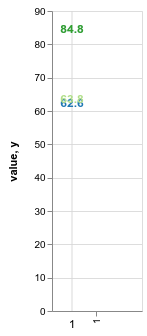

In [154]:
make_rule_between(df_long, type1='fire', i=0)

In [155]:
def make_between_chart(df_long, type1, i, font_size=12, padding=5):
    lines = make_lines(df_long, type1, i)
    rule_between = make_rule_between(df_long, type1, i, font_size=font_size, padding=padding)
    layer_chart = rule_between + lines
    return layer_chart

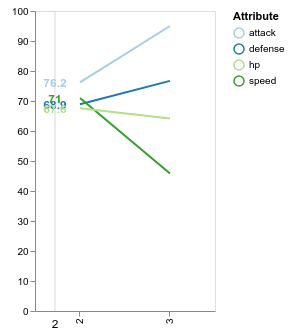

In [156]:
make_between_chart(df_long, 'fire', i=1)

In [157]:
def make_end_chart(df_long, type1, font_size=12, padding=5):
    num_generations = len(df_long.generation.unique())
    num_charts = num_generations - 1
    i = num_charts - 1
    lines = make_lines(df_long, type1, i=i)
    rule = make_rule(df_long, type1, is_start=False, font_size=font_size, padding=padding)
    rule_between = make_rule_between(df_long, type1, i=i, font_size=font_size, padding=padding)
    layer_chart = rule_between + lines + rule
    return layer_chart

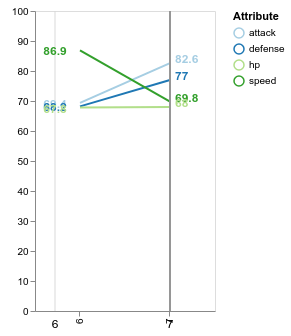

In [158]:
make_end_chart(df_long, 'fire')

In [159]:
def make_slopegraph(df_long, type1, properties):
    """Make a slopegraph (a layer chart of num_charts charts combined together).
    
    TODO: Update when Altair issue #2446 facet customization is closed.
    """   
    charts = []
    num_charts = len(df_long.generation.unique()) - 1
    for i in range(num_charts):
        if i == 0:
            layer_chart = make_start_chart(df_long, type1).properties(**properties)
        elif i == num_charts - 1:
            layer_chart = make_end_chart(df_long, type1).properties(**properties)
        else:
            layer_chart = make_between_chart(df_long, type1, i).properties(**properties)
        charts.append(layer_chart)
        
    slopegraph = facet_wrap(charts, charts_per_row=num_charts)
    return slopegraph

In Altair, only a *top-level chart* can be configured. Namely, once a chart has been configured, it cannot be reconfigured (**CHECK DOCUMENTATION**).

Define configurations and properties, so they can be reused in each slopegraph.

In [160]:
axis_x = {'domain': False, 'ticks': False, 'labels': False}
axis_y = {'domain': False, 'ticks': False, 'labels': False}
scale = {'bandPaddingInner': 1.0, 'bandPaddingOuter': 0.0}
view = {'fill': COLOR_BACKGROUND, 'fillOpacity': 0.5}
# these properties are for a single chart
properties = {'width': 50, 'height': 250}

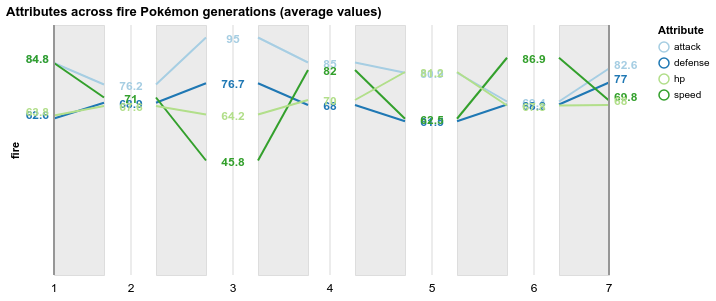

In [161]:
type1 = 'fire'
slopegraph = make_slopegraph(df_long, type1, properties)
slopegraph\
  .configure_axisX(**axis_x)\
  .configure_axisY(**axis_y)\
  .configure_scale(**scale)\
  .configure_view(**view)\
  .properties(title=f'Attributes across {type1} Pokémon generations (average values)')  # for the 6 charts

## Combine all slopegraphs for all Pokémon types

In [162]:
df_long.type1.unique()

array(['bug', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'ghost',
       'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock',
       'water', 'dark', 'steel', 'flying'], dtype=object)

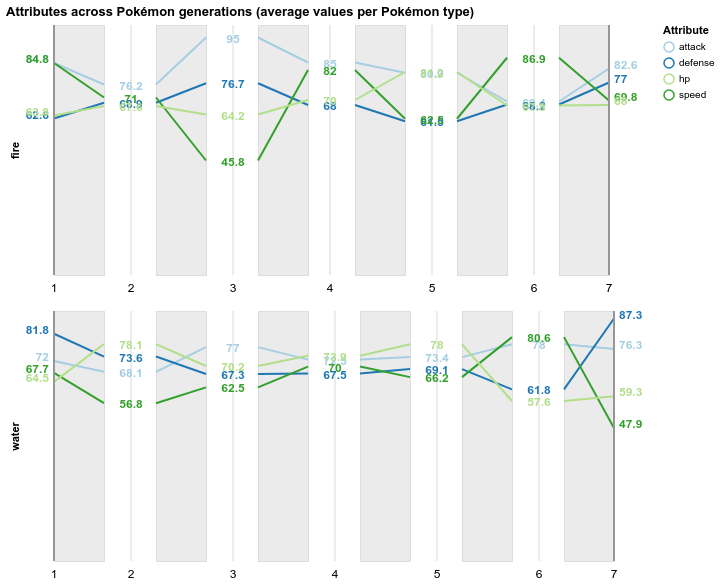

In [163]:
# slopegraphs = [make_slopegraph(df_long, x, properties) for x in ['fire', 'water']]
slopegraphs = [make_slopegraph(df_long, x, properties) for x in df_long.type1.unique()]

compound_slopegraphs = facet_wrap(slopegraphs, charts_per_row=1)\
  .configure_axisX(**axis_x)\
  .configure_axisY(**axis_y)\
  .configure_scale(**scale)\
  .configure_view(**view)\
  .properties(title='Attributes across Pokémon generations (average values per Pokémon type)')

compound_slopegraphs

## Export to HTML

In [102]:
file_path = os.path.abspath(os.path.join(PLOTS_PATH, 'compound_slopegraphs.html'))
compound_slopegraphs.save(file_path)

In [103]:
??alt.MarkDef

In [97]:
??alt.Chart.properties